# Plastic Networks

NEST provides synapse models with a variety of short-term and long-term dynamics. To illustrate this, we extend the sparsely connected network introduced in Example 1 with randomized synaptic weights as described in section 'Randomness in NEST' to incorporate spike-timing-dependent plasticity (Bi and Poo, 1998) at its recurrent excitatory-excitatory synapses.

In [1]:
import pylab
import numpy as np
import nest
import nest.raster_plot



nest.ResetKernel()
n = 4  # number of threads
nest.SetKernelStatus({"local_num_threads": n})

nest.SetKernelStatus({"print_time": True})

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 1. Initializing the network

**Model parameters**

In [2]:
g = 5.0  # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta = 2.0  # rate of external population in multiples of threshold rate
delay = 1.5  # synaptic delay in ms
tau_m = 20.0  # Membrane time constant in mV
V_th = 20.0  # Spike threshold in mV

N_E = 8000
N_I = 2000
N_neurons = N_E + N_I

C_E = int(N_E / 10)  # number of excitatory synapses per neuron
C_I = int(N_I / 10)  # number of inhibitory synapses per neuron

J_E = 0.1
J_I = -g * J_E

nu_ex = eta * V_th / (J_E * C_E * tau_m)  # rate of an external neuron in ms^-1
p_rate = 1000.0 * nu_ex * C_E  # rate of the external population in s^-1

In [3]:
# Synaptic parameters
STDP_alpha = 2.02  # relative strength of STDP depression w.r.t potentiation
STDP_Wmax = 3 * J_E  # maximum weight of plastic synapse

# Simulation parameters
N_vp = 8  # number of virtual processes to use
base_seed = 10000  # increase in intervals of at least 2*n_vp+1
N_rec = 50  # Number of neurons to record from
data2file = True  # whether to record data to file
simtime = 300.0  # how long shall we simulate [ms]

**Create and seed RNGs**

In [4]:
nest.ResetKernel()

# Set parameters of the NEST simulation kernel
nest.SetKernelStatus({"print_time": True, "local_num_threads": 2})

# Create and seed RNGs
ms = 1000  # master seed
n_vp = nest.GetKernelStatus("total_num_virtual_procs")
pyrngs = [np.random.RandomState(s) for s in range(ms, ms + n_vp)]

# Create nodes -------------------------------------------------

nest.SetDefaults(
    "iaf_psc_delta",
    {
        "C_m": 1.0,
        "tau_m": tau_m,
        "t_ref": 2.0,
        "E_L": 0.0,
        "V_th": V_th,
        "V_reset": 10.0,
    },
)

nodes = nest.Create("iaf_psc_delta", N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

noise = nest.Create("poisson_generator", 1, {"rate": p_rate})

spikes = nest.Create(
    "spike_recorder", 2, [{"label": "brunel_py_ex"}, {"label": "brunel_py_in"}]
)
spikes_E = spikes[:1]
spikes_I = spikes[1:]

nest.CopyModel(
    "stdp_synapse_hom", "excitatory_plastic", {"alpha": STDP_alpha, "Wmax": STDP_Wmax}
)
nest.CopyModel("static_synapse", "excitatory_static")

**Connect**

In [5]:
nest.Connect(
    nodes_E,
    nodes_E,
    {"rule": "fixed_indegree", "indegree": C_E},
    {
        "synapse_model": "excitatory_plastic",
        "delay": delay,
        "weight": nest.random.uniform(min=0.5 * J_E, max=1.5 * J_E),
    },
)
nest.Connect(
    nodes_E,
    nodes_I,
    {"rule": "fixed_indegree", "indegree": C_E},
    {
        "synapse_model": "excitatory_static",
        "delay": delay,
        "weight": nest.random.uniform(min=0.5 * J_E, max=1.5 * J_E),
    },
)
nest.CopyModel(
    "static_synapse",
    "inhibitory",
    {"weight": J_I, "delay": delay},
)
nest.Connect(
    nodes_I,
    nodes,
    {"rule": "fixed_indegree", "indegree": C_I},
    "inhibitory",
)

In [6]:
# connect noise generator to all neurons
nest.CopyModel(
    "static_synapse_hom_w", "excitatory_input", {"weight": J_E, "delay": delay}
)
nest.Connect(noise, nodes, syn_spec="excitatory_input")

# connect all recorded E/I neurons to the respective detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)


Apr 01 13:08:54 NodeManager::prepare_nodes [Info]: 
    Preparing 10006 nodes for simulation.
Excitatory rate   : 36.40 Hz
Inhibitory rate   : 38.32 Hz

Apr 01 13:08:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10006
    Simulation time (ms): 500
    Number of OpenMP threads: 2
    Number of MPI processes: 1

[ 100% ] Model time: 500.0 ms, Real-time factor: 44.1310

Apr 01 13:09:16 SimulationManager::run [Info]: 
    Simulation finished.


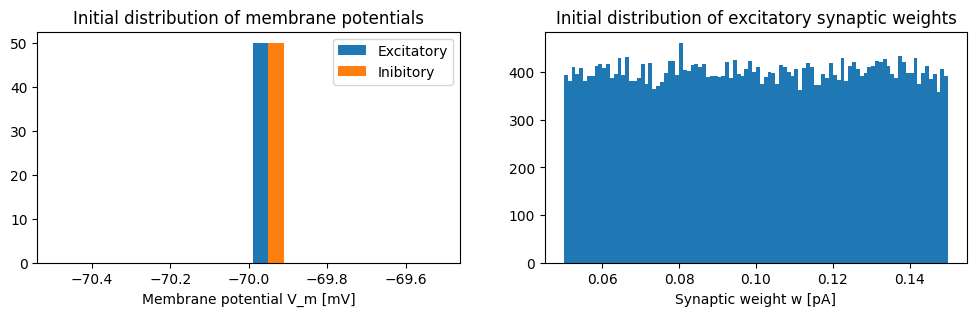

In [7]:
simtime = 500

if nest.NumProcesses() == 1:

    pylab.figure(figsize=(12, 3))

    # membrane potential
    V_E = nest.GetStatus(nodes_E[:N_rec], "V_m")
    V_I = nest.GetStatus(nodes_I[:N_rec], "V_m")
    pylab.subplot(121)
    pylab.hist([V_E, V_I], bins=10)
    pylab.xlabel("Membrane potential V_m [mV]")
    pylab.legend(("Excitatory", "Inibitory"))
    pylab.title("Initial distribution of membrane potentials")
    pylab.draw()

    # weight of excitatory connections
    w = nest.GetStatus(
        nest.GetConnections(nodes_E[:N_rec], synapse_model="excitatory_plastic"),
        "weight",
    )

    pylab.subplot(122)
    pylab.hist(w, bins=100)
    pylab.xlabel("Synaptic weight w [pA]")
    pylab.title("Initial distribution of excitatory synaptic weights")
    pylab.draw()

else:
    print("Multiple MPI processes, skipping graphical output")

nest.Simulate(simtime)

events = nest.GetStatus(spikes, "n_events")

# Before we compute the rates, we need to know how many of the recorded
# neurons are on the local MPI process
N_rec_local_E = sum(nest.GetStatus(nodes_E[:N_rec], "local"))
rate_ex = events[0] / simtime * 1000.0 / N_rec_local_E
print("Excitatory rate   : {:.2f} Hz".format(rate_ex))

N_rec_local_I = sum(nest.GetStatus(nodes_I[:N_rec], "local"))
rate_in = events[1] / simtime * 1000.0 / N_rec_local_I
print("Inhibitory rate   : {:.2f} Hz".format(rate_in))

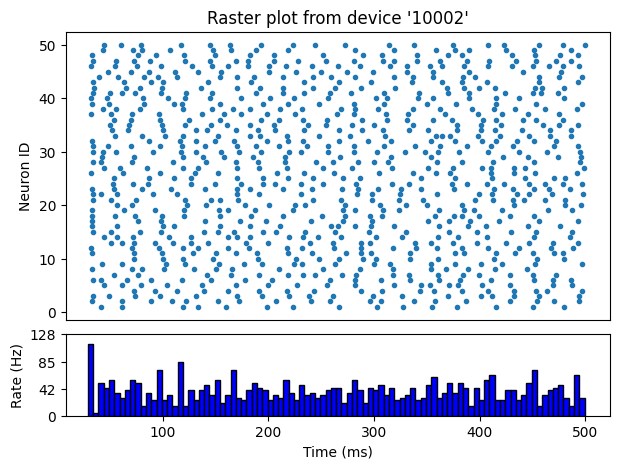

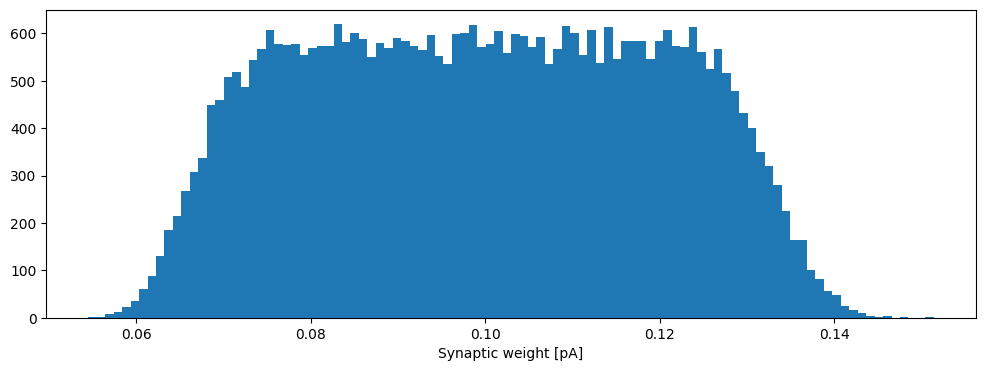

In [8]:
if nest.NumProcesses() == 1:
    nest.raster_plot.from_device(spikes_E, hist=True)
    # weight of excitatory connections
    w = nest.GetStatus(
        nest.GetConnections(nodes_E[:N_rec], synapse_model="excitatory_plastic"),
        "weight",
    )
    pylab.figure(figsize=(12, 4))
    pylab.hist(w, bins=100)
    pylab.xlabel("Synaptic weight [pA]")
    # pylab.savefig('../figures/rand_plas_w.eps')
    # pylab.show()

else:
    print("Multiple MPI processes, skipping graphical output")